# Fully convolutional Networks for Semantic Segmentation
https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

In [1]:
"""googlecolab = True

if googlecolab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    #!pip install Pillow==4.1.1"""

"googlecolab = True\n\nif googlecolab:\n    from os.path import exists\n    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag\n    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())\n    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\\.\\([0-9]*\\)\\.\\([0-9]*\\)$/cu\x01\x02/'\n    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'\n\n    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision\n    #!pip install Pillow==4.1.1"

In [2]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from torch.utils.tensorboard import SummaryWriter




## Dataset : Pascal VOC 2007

In [3]:
dataroot = '/home/yannis/Documents/stage_segmentation/dataset/voc2007'
dset.VOCSegmentation(dataroot,year='2007', image_set='train', download=True)


Using downloaded and verified file: /home/yannis/Documents/stage_segmentation/dataset/voc2007/VOCtrainval_06-Nov-2007.tar


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: /home/yannis/Documents/stage_segmentation/dataset/voc2007

In [4]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1


class PascalVOCDataset(Dataset):
    """Pascal VOC 2007 Dataset"""
    def __init__(self, list_file, img_dir, mask_dir, transform=None):
        self.images = open(list_file, "rt").read().split("\n")[:-1]
        self.transform = transform

        self.img_extension = ".jpg"
        self.mask_extension = ".png"

        self.image_root_dir = img_dir
        self.mask_root_dir = mask_dir

        self.counts = self.__compute_class_probability()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        name = self.images[index]
        image_path = os.path.join(self.image_root_dir, name + self.img_extension)
        mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

        image = self.load_image(path=image_path)
        gt_mask = self.load_mask(path=mask_path)

        data = {
                    'image': torch.FloatTensor(image),
                    'mask' : torch.LongTensor(gt_mask)
                    }

        return data

    def __compute_class_probability(self):
        counts = dict((i, 0) for i in range(NUM_CLASSES))

        for name in self.images:
            mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

            raw_image = Image.open(mask_path).resize((224, 224))
            imx_t = np.array(raw_image).reshape(224*224)
            imx_t[imx_t==255] = len(VOC_CLASSES)

            for i in range(NUM_CLASSES):
                counts[i] += np.sum(imx_t == i)

        return counts

    def get_class_probability(self):
        values = np.array(list(self.counts.values()))
        p_values = values/np.sum(values)

        return torch.Tensor(p_values)

    def load_image(self, path=None):
        raw_image = Image.open(path)
        raw_image = np.transpose(raw_image.resize((224, 224)), (2,1,0))
        imx_t = np.array(raw_image, dtype=np.float32)/255.0

        return imx_t

    def load_mask(self, path=None):
        raw_image = Image.open(path)
        raw_image = raw_image.resize((224, 224))
        imx_t = np.array(raw_image)
        # border
        imx_t[imx_t==255] = len(VOC_CLASSES)

        return imx_t


data_root = os.path.join(dataroot,'VOCdevkit','VOC2007')
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "train.txt")
img_dir = os.path.join(data_root, "JPEGImages")
mask_dir = os.path.join(data_root, "SegmentationObject")

## Train
train_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)

## train_val 
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "trainval.txt")

trainval_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)
## val
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "val.txt")

val_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)



device : cuda:0


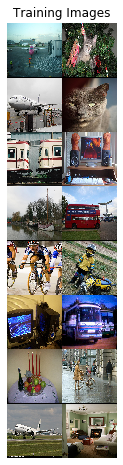

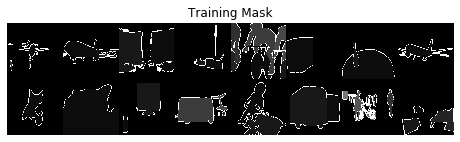

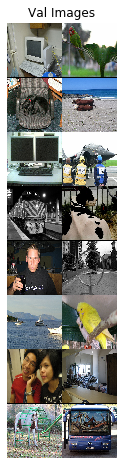

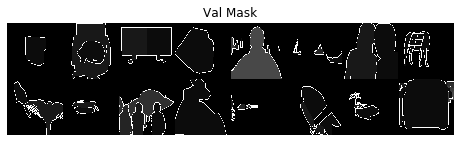

In [21]:

# Set batch_size
batch_size = 20

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dataloader_train_val = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['image'].float()[:16], padding=2, normalize=True).cpu()))
plt.show()

rb=torch.stack([real_batch['mask'],real_batch['mask'],real_batch['mask']],dim=1)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Mask")
plt.imshow(np.transpose(vutils.make_grid(rb.float()[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Plot some val images
real_batch = next(iter(dataloader_val))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Val Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['image'][:16], padding=2, normalize=True).cpu()))
plt.show()
rb=torch.stack([real_batch['mask'],real_batch['mask'],real_batch['mask']],dim=1)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Val Mask")
plt.imshow(np.transpose(vutils.make_grid(rb.float().to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### info datasets

In [6]:
print("Taille dataset train :",len(train_dataset))
print("Taille dataset trainval :",len(trainval_dataset))
print("Taille dataset val :",len(val_dataset))

Taille dataset train : 209
Taille dataset trainval : 422
Taille dataset val : 213


tensor([7.0276e-01, 1.6168e-01, 5.0462e-02, 1.1129e-02, 1.2878e-02, 5.9402e-03,
        3.4075e-03, 2.2567e-03, 4.1291e-04, 6.9558e-04, 4.2844e-04, 7.3918e-06,
        6.1754e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7943e-02])


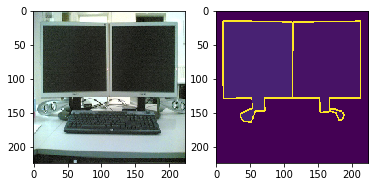

In [7]:
print(val_dataset.get_class_probability())

sample = val_dataset[2]
image, mask = sample['image'], sample['mask']

image.transpose_(0, 2)

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [8]:
image.size()

torch.Size([224, 224, 3])

In [9]:
mask.size()

torch.Size([224, 224])

## Metric code

### pixel accuracy 

### mean accuracy

### IOU

In [10]:
SMOOTH = 1e-6
def iou(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou  # Or thresholded.mean() if you are interested in average across the batch
    

In [11]:
iou(next(iter(dataloader_train))['mask'],next(iter(dataloader_train_val))['mask'])

tensor([1.0000, 1.0000, 0.0368, 0.0423, 0.0326, 0.0329, 0.0350, 0.0747, 0.0352,
        0.0156, 0.0211, 0.0415, 0.0511, 0.0094, 0.0347, 0.0183, 0.0671, 0.0354,
        0.0781, 0.0189, 0.0463, 0.0777, 0.0972, 0.0701, 0.0626, 0.0841, 0.0277,
        0.0686, 0.0510, 0.0425, 0.0248, 0.0367, 0.1609, 0.0583, 0.0659, 0.0333,
        0.0423, 0.0896, 0.0520, 0.0225, 0.0349, 0.1129, 0.0576, 0.1251, 0.1387,
        0.0350, 0.0992, 0.0710, 0.0803, 0.0624, 0.0729, 0.0567, 0.0243, 0.0611,
        0.0287, 0.0694, 0.0315, 0.0211, 0.0415, 0.0442, 0.0879, 0.0719, 0.0495,
        0.0844])

### frequency weighted IU

## FCN for Semantic Segmentation models

### Premièrement il faut charger un modèle bgg16 préentrainé sur imageNet.

In [12]:
print('Instanciation de VGG16')
vgg16 = models.vgg16(pretrained=True)
vgg16

Instanciation de VGG16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
batch_test = next(iter(dataloader_train))['image']
output_f = vgg16.features(batch_test)

In [14]:
output_f.size()

torch.Size([64, 512, 7, 7])

### On implémente le modèle FCN -32s du papier en gardant les couches convolutives de vgg16

In [15]:
class FCN32_VGG16(torch.nn.Module): # Archi FCN-32s du papier
    def __init__(self,vgg16):
        super(FCN32_VGG16,self).__init__()
        self.features_im_net = nn.Sequential(*list(vgg16.features.children()))
        # On ne considère que les features et on supprime les couches fully connected.
        # pour les remplacer par des conv 
        # on ne garde pas l'avg pool
        # [512,7,7]
        self.conv_classif = nn.Sequential(
            
            nn.Conv2d(512,64,kernel_size=(3,3),stride=(2,2),padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,21,kernel_size=(3,3),stride=(1,1),padding=0)
        )
        # [21,1,1]
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(21,1,kernel_size=(7,7)), # Pas sur mais pour augmenter d'un facteur 32 pour arriver à 224
            #, il nous faut des fmaps de taille 7 #Pas sur pour dim_out =1 non plus.
            nn.UpsamplingBilinear2d(scale_factor=32)

        )
        


    def forward(self,x):
        x = self.features_im_net(x)
        x = self.conv_classif(x)
        x = self.upsampling(x)        
        return x # [224,224]

### Rapide test si les dimensions et le modèle sont ok

In [16]:
model = FCN32_VGG16(vgg16)

In [17]:
batch_test = next(iter(dataloader_train))['image']
output_f = model(batch_test)

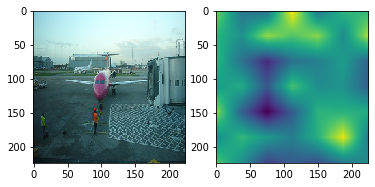

In [18]:

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(batch_test[0]))

a = fig.add_subplot(1,2,2)
plt.imshow(output_f[0][0].detach().numpy())

plt.show() # test si image meme dimension et si un batch passe dans le réseau 

## Training

In [ ]:
learning_rate = 10e-4
moment = 0.9
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=moment)